# Machine Learning Foundation

## Section 1, Part d: Feature Engineering 

## Feature Engineering with Linear Regression: Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf

In this notebook, we will build some linear regression models to predict housing prices from this data. In particular, we will set out to improve on a baseline set of features via **feature engineering**: deriving new features from our existing data. Feature engineering often makes the difference between a weak model and a strong one.

We will use visual exploration, domain understanding, and intuition to construct new features that will be useful later in the course as we turn to prediction.

**Notebook Contents**

> 1. Simple EDA 
> 2. One-hot Encoding variables
> 3. Log transformation for skewed variables
> 4. Pair plot for features
> 5. Basic feature engineering: adding polynomial and interaction terms
> 6. Feature engineering: categories and features derived from category aggregates 

## 1. Simple EDA 

In [2]:
import numpy as np
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


#### Load the Data, Examine and Explore

In [5]:
## Load in the Ames Housing Data
datafile = "data/Ames_Housing_Data.tsv"
df = pd.read_csv(datafile, sep='\t')

In [3]:
## Examine the columns, look at missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [25]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area'] <= 4000,:]
print("Number of rows in the data:", df.shape[0])
print("Number of columns in the data:", df.shape[1])
data = df.copy() # Keep a copy our original data 

Number of rows in the data: 2930
Number of columns in the data: 80


In [15]:
# A quick look at the data:
df.head()



Order        PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
0      1  526301100           20         141.0     31770             6   
1      2  526350040           20          80.0     11622             5   
2      3  526351010           20          81.0     14267             6   
3      4  526353030           20          93.0     11160             7   
4      5  527105010           60          74.0     13830             5   

   Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area  ...  \
0             5        1960            1960         112.0  ...   
1             6        1961            1961           0.0  ...   
2             6        1958            1958         108.0  ...   
3             5        1968            1968           0.0  ...   
4             5        1997            1998           0.0  ...   

   Sale Type_ConLw  Sale Type_New  Sale Type_Oth  Sale Type_VWD  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   

   Sale Type_WD   Sale Condition_AdjLand  Sale Condition_Alloca  \
0              1                       0                      0   
1              1                       0                      0   
2              1                       0                      0   
3              1                       0                      0   
4              1                       0                      0   

   Sale Condition_Family  Sale Condition_Normal  Sale Condition_Partial  
0                      0                      1                       0  
1                      0                      1                       0  
2                      0                      1                       0  
3                      0                      1                       0  
4                      0                      1                       0  

[5 rows x 262 columns]

In [6]:
len(df.Order.unique())

2930

In [7]:
#Dropping columns for which every value is unique.
#Will not add any values to our eventual model

df.drop(['PID','Order'],axis=1,inplace=True)
df.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0           20        RL         141.0     31770   Pave   NaN       IR1   
1           20        RH          80.0     11622   Pave   NaN       Reg   
2           20        RL          81.0     14267   Pave   NaN       IR1   
3           20        RL          93.0     11160   Pave   NaN       Reg   
4           60        RL          74.0     13830   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Pool Area Pool QC  Fence  \
0          Lvl    AllPub     Corner  ...         0     NaN    NaN   
1          Lvl    AllPub     Inside  ...         0     NaN  MnPrv   
2          Lvl    AllPub     Corner  ...         0     NaN    NaN   
3          Lvl    AllPub     Corner  ...         0     NaN    NaN   
4          Lvl    AllPub     Inside  ...         0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Condition  SalePrice  
0          NaN        0       5     2010        WD           Normal     215000  
1          NaN        0       6     2010        WD           Normal     105000  
2         Gar2    12500       6     2010        WD           Normal     172000  
3          NaN        0       4     2010        WD           Normal     244000  
4          NaN        0       3     2010        WD           Normal     189900  

[5 rows x 80 columns]

We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

### One-hot encoding for dummy variables:

In [14]:
#Create a list of float columns to check for skewing
num_cols=df.select_dtypes('number').columns
skew_limit = 0.75 #for skew value above this, we apply log transformation
skew_vals = df[num_cols].skew()
skew_vals



MS SubClass         1.357579
Lot Frontage        1.499067
Lot Area           12.820898
Overall Qual        0.190634
Overall Cond        0.574429
Year Built         -0.604462
Year Remod/Add     -0.451863
Mas Vnr Area        2.606985
BsmtFin SF 1        1.416182
BsmtFin SF 2        4.139978
Bsmt Unf SF         0.923053
Total Bsmt SF       1.156204
1st Flr SF          1.469429
2nd Flr SF          0.866457
Low Qual Fin SF    12.118162
Gr Liv Area         1.274110
Bsmt Full Bath      0.616639
Bsmt Half Bath      3.940795
Full Bath           0.171952
Half Bath           0.697713
Bedroom AbvGr       0.305694
Kitchen AbvGr       4.313825
TotRms AbvGrd       0.753543
Fireplaces          0.739215
Garage Yr Blt      -0.384672
Garage Cars        -0.219836
Garage Area         0.241994
Wood Deck SF        1.842678
Open Porch SF       2.535386
Enclosed Porch      4.014446
3Ssn Porch         11.403795
Screen Porch        3.957467
Pool Area          16.939142
Misc Val           21.999788
Mo Sold       

In [15]:
skew_cols = skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

Misc Val           21.999788
Pool Area          16.939142
Lot Area           12.820898
Low Qual Fin SF    12.118162
3Ssn Porch         11.403795
Kitchen AbvGr       4.313825
BsmtFin SF 2        4.139978
Enclosed Porch      4.014446
Screen Porch        3.957467
Bsmt Half Bath      3.940795
Mas Vnr Area        2.606985
Open Porch SF       2.535386
Wood Deck SF        1.842678
SalePrice           1.743500
Lot Frontage        1.499067
1st Flr SF          1.469429
BsmtFin SF 1        1.416182
MS SubClass         1.357579
Gr Liv Area         1.274110
Total Bsmt SF       1.156204
Bsmt Unf SF         0.923053
2nd Flr SF          0.866457
TotRms AbvGrd       0.753543
dtype: float64

<AxesSubplot:>

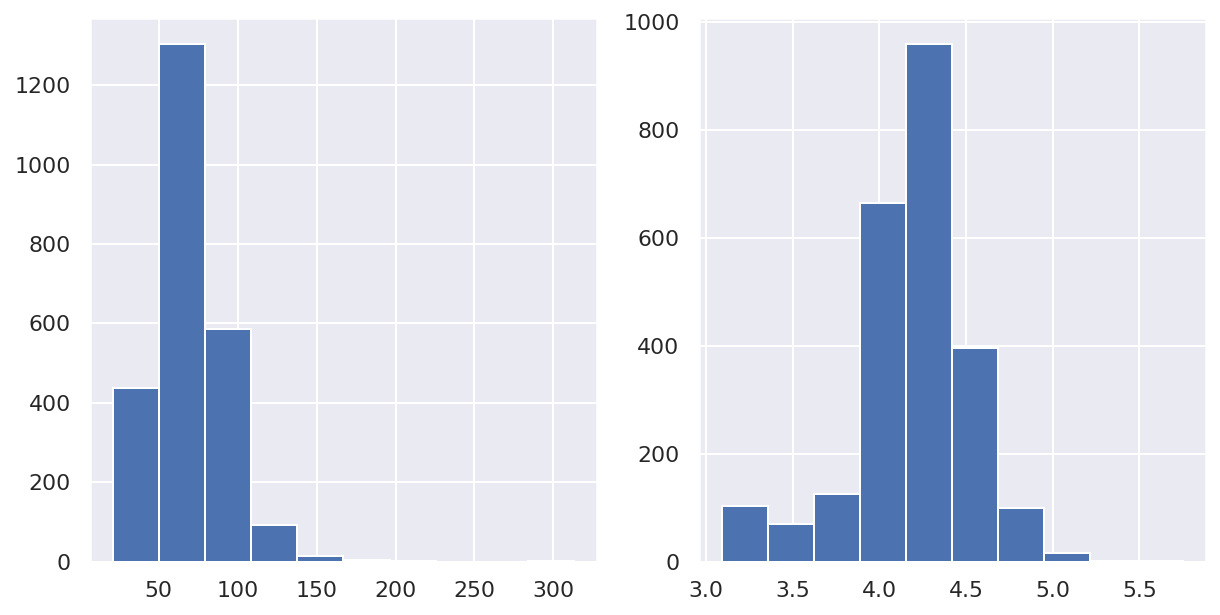

In [20]:
#check out what a skewed variable distribution looks like
#check status of plot before and after skewing
field = 'Lot Frontage'
fig, (ax_before,ax_after) = plt.subplots(1,2 , figsize=(10,5))
df[field].hist(ax=ax_before)
df[field].apply(np.log1p).hist(ax=ax_after)

In [30]:
data.isnull().sum().sort_values()
#filter out some columns from the entire df
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond',
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area',
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces',
                      'Garage Cars','SalePrice']]

In [23]:
#perform log transformations on every skewed variable except the one we just skewed above
for col in skew_cols.index.values:
    if col == 'Lot Frontage':
        continue
    df[col] = df[col].apply(np.log1p)



In [6]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = df.dtypes[df.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

df[one_hot_encode_cols].head().T

<ipython-input-6-d9fd5802aa7a>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_encode_cols = df.dtypes[df.dtypes == np.object]  # filtering by string categoricals


0        1        2        3        4
MS Zoning            RL       RH       RL       RL       RL
Street             Pave     Pave     Pave     Pave     Pave
Alley               NaN      NaN      NaN      NaN      NaN
Lot Shape           IR1      Reg      IR1      Reg      IR1
Land Contour        Lvl      Lvl      Lvl      Lvl      Lvl
Utilities        AllPub   AllPub   AllPub   AllPub   AllPub
Lot Config       Corner   Inside   Corner   Corner   Inside
Land Slope          Gtl      Gtl      Gtl      Gtl      Gtl
Neighborhood      NAmes    NAmes    NAmes    NAmes  Gilbert
Condition 1        Norm    Feedr     Norm     Norm     Norm
Condition 2        Norm     Norm     Norm     Norm     Norm
Bldg Type          1Fam     1Fam     1Fam     1Fam     1Fam
House Style      1Story   1Story   1Story   1Story   2Story
Roof Style          Hip    Gable      Hip      Hip    Gable
Roof Matl       CompShg  CompShg  CompShg  CompShg  CompShg
Exterior 1st    BrkFace  VinylSd  Wd Sdng  BrkFace  VinylSd
Exterior 2nd    Plywood  VinylSd  Wd Sdng  BrkFace  VinylSd
Mas Vnr Type      Stone     None  BrkFace     None     None
Exter Qual           TA       TA       TA       Gd       TA
Exter Cond           TA       TA       TA       TA       TA
Foundation       CBlock   CBlock   CBlock   CBlock    PConc
Bsmt Qual            TA       TA       TA       TA       Gd
Bsmt Cond            Gd       TA       TA       TA       TA
Bsmt Exposure        Gd       No       No       No       No
BsmtFin Type 1      BLQ      Rec      ALQ      ALQ      GLQ
BsmtFin Type 2      Unf      LwQ      Unf      Unf      Unf
Heating            GasA     GasA     GasA     GasA     GasA
Heating QC           Fa       TA       TA       Ex       Gd
Central Air           Y        Y        Y        Y        Y
Electrical        SBrkr    SBrkr    SBrkr    SBrkr    SBrkr
Kitchen Qual         TA       TA       Gd       Ex       TA
Functional          Typ      Typ      Typ      Typ      Typ
Fireplace Qu         Gd      NaN      NaN       TA       TA
Garage Type      Attchd   Attchd   Attchd   Attchd   Attchd
Garage Finish       Fin      Unf      Unf      Fin      Fin
Garage Qual          TA       TA       TA       TA       TA
Garage Cond          TA       TA       TA       TA       TA
Paved Drive           P        Y        Y        Y        Y
Pool QC             NaN      NaN      NaN      NaN      NaN
Fence               NaN    MnPrv      NaN      NaN    MnPrv
Misc Feature        NaN      NaN     Gar2      NaN      NaN
Sale Type           WD       WD       WD       WD       WD 
Sale Condition   Normal   Normal   Normal   Normal   Normal

We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

#### One-hot encoding the dummy variables:

In [7]:
# Do the one hot encoding
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)
df.describe().T

count          mean           std          min  \
Order                   2925.0  1.464795e+03  8.464417e+02          1.0   
PID                     2925.0  7.143931e+08  1.887274e+08  526301100.0   
MS SubClass             2925.0  5.739658e+01  4.266875e+01         20.0   
Lot Frontage            2435.0  6.902382e+01  2.271092e+01         21.0   
Lot Area                2925.0  1.010358e+04  7.781999e+03       1300.0   
...                        ...           ...           ...          ...   
Sale Condition_AdjLand  2925.0  4.102564e-03  6.393067e-02          0.0   
Sale Condition_Alloca   2925.0  8.205128e-03  9.022520e-02          0.0   
Sale Condition_Family   2925.0  1.572650e-02  1.244366e-01          0.0   
Sale Condition_Normal   2925.0  8.246154e-01  3.803608e-01          0.0   
Sale Condition_Partial  2925.0  8.273504e-02  2.755284e-01          0.0   

                                25%          50%          75%           max  
Order                         732.0       1463.0       2199.0  2.930000e+03  
PID                     528477030.0  535453210.0  907180130.0  1.007100e+09  
MS SubClass                    20.0         50.0         70.0  1.900000e+02  
Lot Frontage                   58.0         68.0         80.0  3.130000e+02  
Lot Area                     7438.0       9428.0      11515.0  2.152450e+05  
...                             ...          ...          ...           ...  
Sale Condition_AdjLand          0.0          0.0          0.0  1.000000e+00  
Sale Condition_Alloca           0.0          0.0          0.0  1.000000e+00  
Sale Condition_Family           0.0          0.0          0.0  1.000000e+00  
Sale Condition_Normal           1.0          1.0          1.0  1.000000e+00  
Sale Condition_Partial          0.0          0.0          0.0  1.000000e+00  

[262 rows x 8 columns]

### Log transforming skew variables

In [9]:
# Create a list of float colums to check for skewing
mask = data.dtypes == np.float
float_cols = data.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = data[float_cols].skew()

<ipython-input-9-6e778ec8cb23>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = data.dtypes == np.float


In [10]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

Skew
BsmtFin SF 2    4.135900
Bsmt Half Bath  3.965970
Mas Vnr Area    2.565458
Lot Frontage    1.111071
Bsmt Unf SF     0.925021
BsmtFin SF 1    0.821985

In [ ]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "BsmtFin SF 1"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
df[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
df[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [ ]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    if col == "SalePrice":
        continue
    df[col] = df[col].apply(np.log1p)

In [ ]:
# We now have a larger set of potentially-useful features
df.shape

In [ ]:
# There are a *lot* of variables. Let's go back to our saved original data and look at how many values are missing for each variable. 
df = data
data.isnull().sum().sort_values()

 Let's pick out just a few numeric columns to illustrate basic feature transformations.

In [31]:
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars','SalePrice']]

In [32]:
# Now we can look at summary statistics of the subset data
smaller_df.describe().T

count         mean        std          min          25%  \
Lot Area        2930.0     2.310463   0.051652     2.100578     2.294028   
Overall Qual    2930.0     6.094881   1.411026     1.000000     5.000000   
Overall Cond    2930.0     5.563140   1.111537     1.000000     5.000000   
Year Built      2930.0  1971.356314  30.245361  1872.000000  1954.000000   
Year Remod/Add  2930.0  1984.266553  20.860286  1950.000000  1965.000000   
Gr Liv Area     2930.0     2.110757   0.039345     1.918998     2.082850   
Full Bath       2930.0     1.566553   0.552941     0.000000     1.000000   
Bedroom AbvGr   2930.0     2.854266   0.827731     0.000000     2.000000   
Fireplaces      2930.0     0.599317   0.647921     0.000000     0.000000   
Garage Cars     2929.0     1.766815   0.760566     0.000000     1.000000   
SalePrice       2930.0     2.566071   0.031372     2.347216     2.547212   

                        50%          75%          max  
Lot Area           2.317715     2.337468     2.586224  
Overall Qual       6.000000     7.000000    10.000000  
Overall Cond       5.000000     6.000000     9.000000  
Year Built      1973.000000  2001.000000  2010.000000  
Year Remod/Add  1993.000000  2004.000000  2010.000000  
Gr Liv Area        2.113176     2.135797     2.265731  
Full Bath          2.000000     2.000000     4.000000  
Bedroom AbvGr      3.000000     3.000000     8.000000  
Fireplaces         1.000000     1.000000     4.000000  
Garage Cars        2.000000     2.000000     5.000000  
SalePrice          2.563636     2.585611     2.676523

In [33]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2930 non-null   float64
 1   Overall Qual    2930 non-null   int64  
 2   Overall Cond    2930 non-null   int64  
 3   Year Built      2930 non-null   int64  
 4   Year Remod/Add  2930 non-null   int64  
 5   Gr Liv Area     2930 non-null   float64
 6   Full Bath       2930 non-null   int64  
 7   Bedroom AbvGr   2930 non-null   int64  
 8   Fireplaces      2930 non-null   int64  
 9   Garage Cars     2929 non-null   float64
 10  SalePrice       2930 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 274.7 KB


In [35]:
# There appears to be one NA in Garage Cars - we will take a simple approach and fill it with 0
smaller_df = smaller_df.fillna(0)

In [36]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2930 non-null   float64
 1   Overall Qual    2930 non-null   int64  
 2   Overall Cond    2930 non-null   int64  
 3   Year Built      2930 non-null   int64  
 4   Year Remod/Add  2930 non-null   int64  
 5   Gr Liv Area     2930 non-null   float64
 6   Full Bath       2930 non-null   int64  
 7   Bedroom AbvGr   2930 non-null   int64  
 8   Fireplaces      2930 non-null   int64  
 9   Garage Cars     2930 non-null   float64
 10  SalePrice       2930 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 274.7 KB



### Pair plot of features
Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: pairplot is great for this!

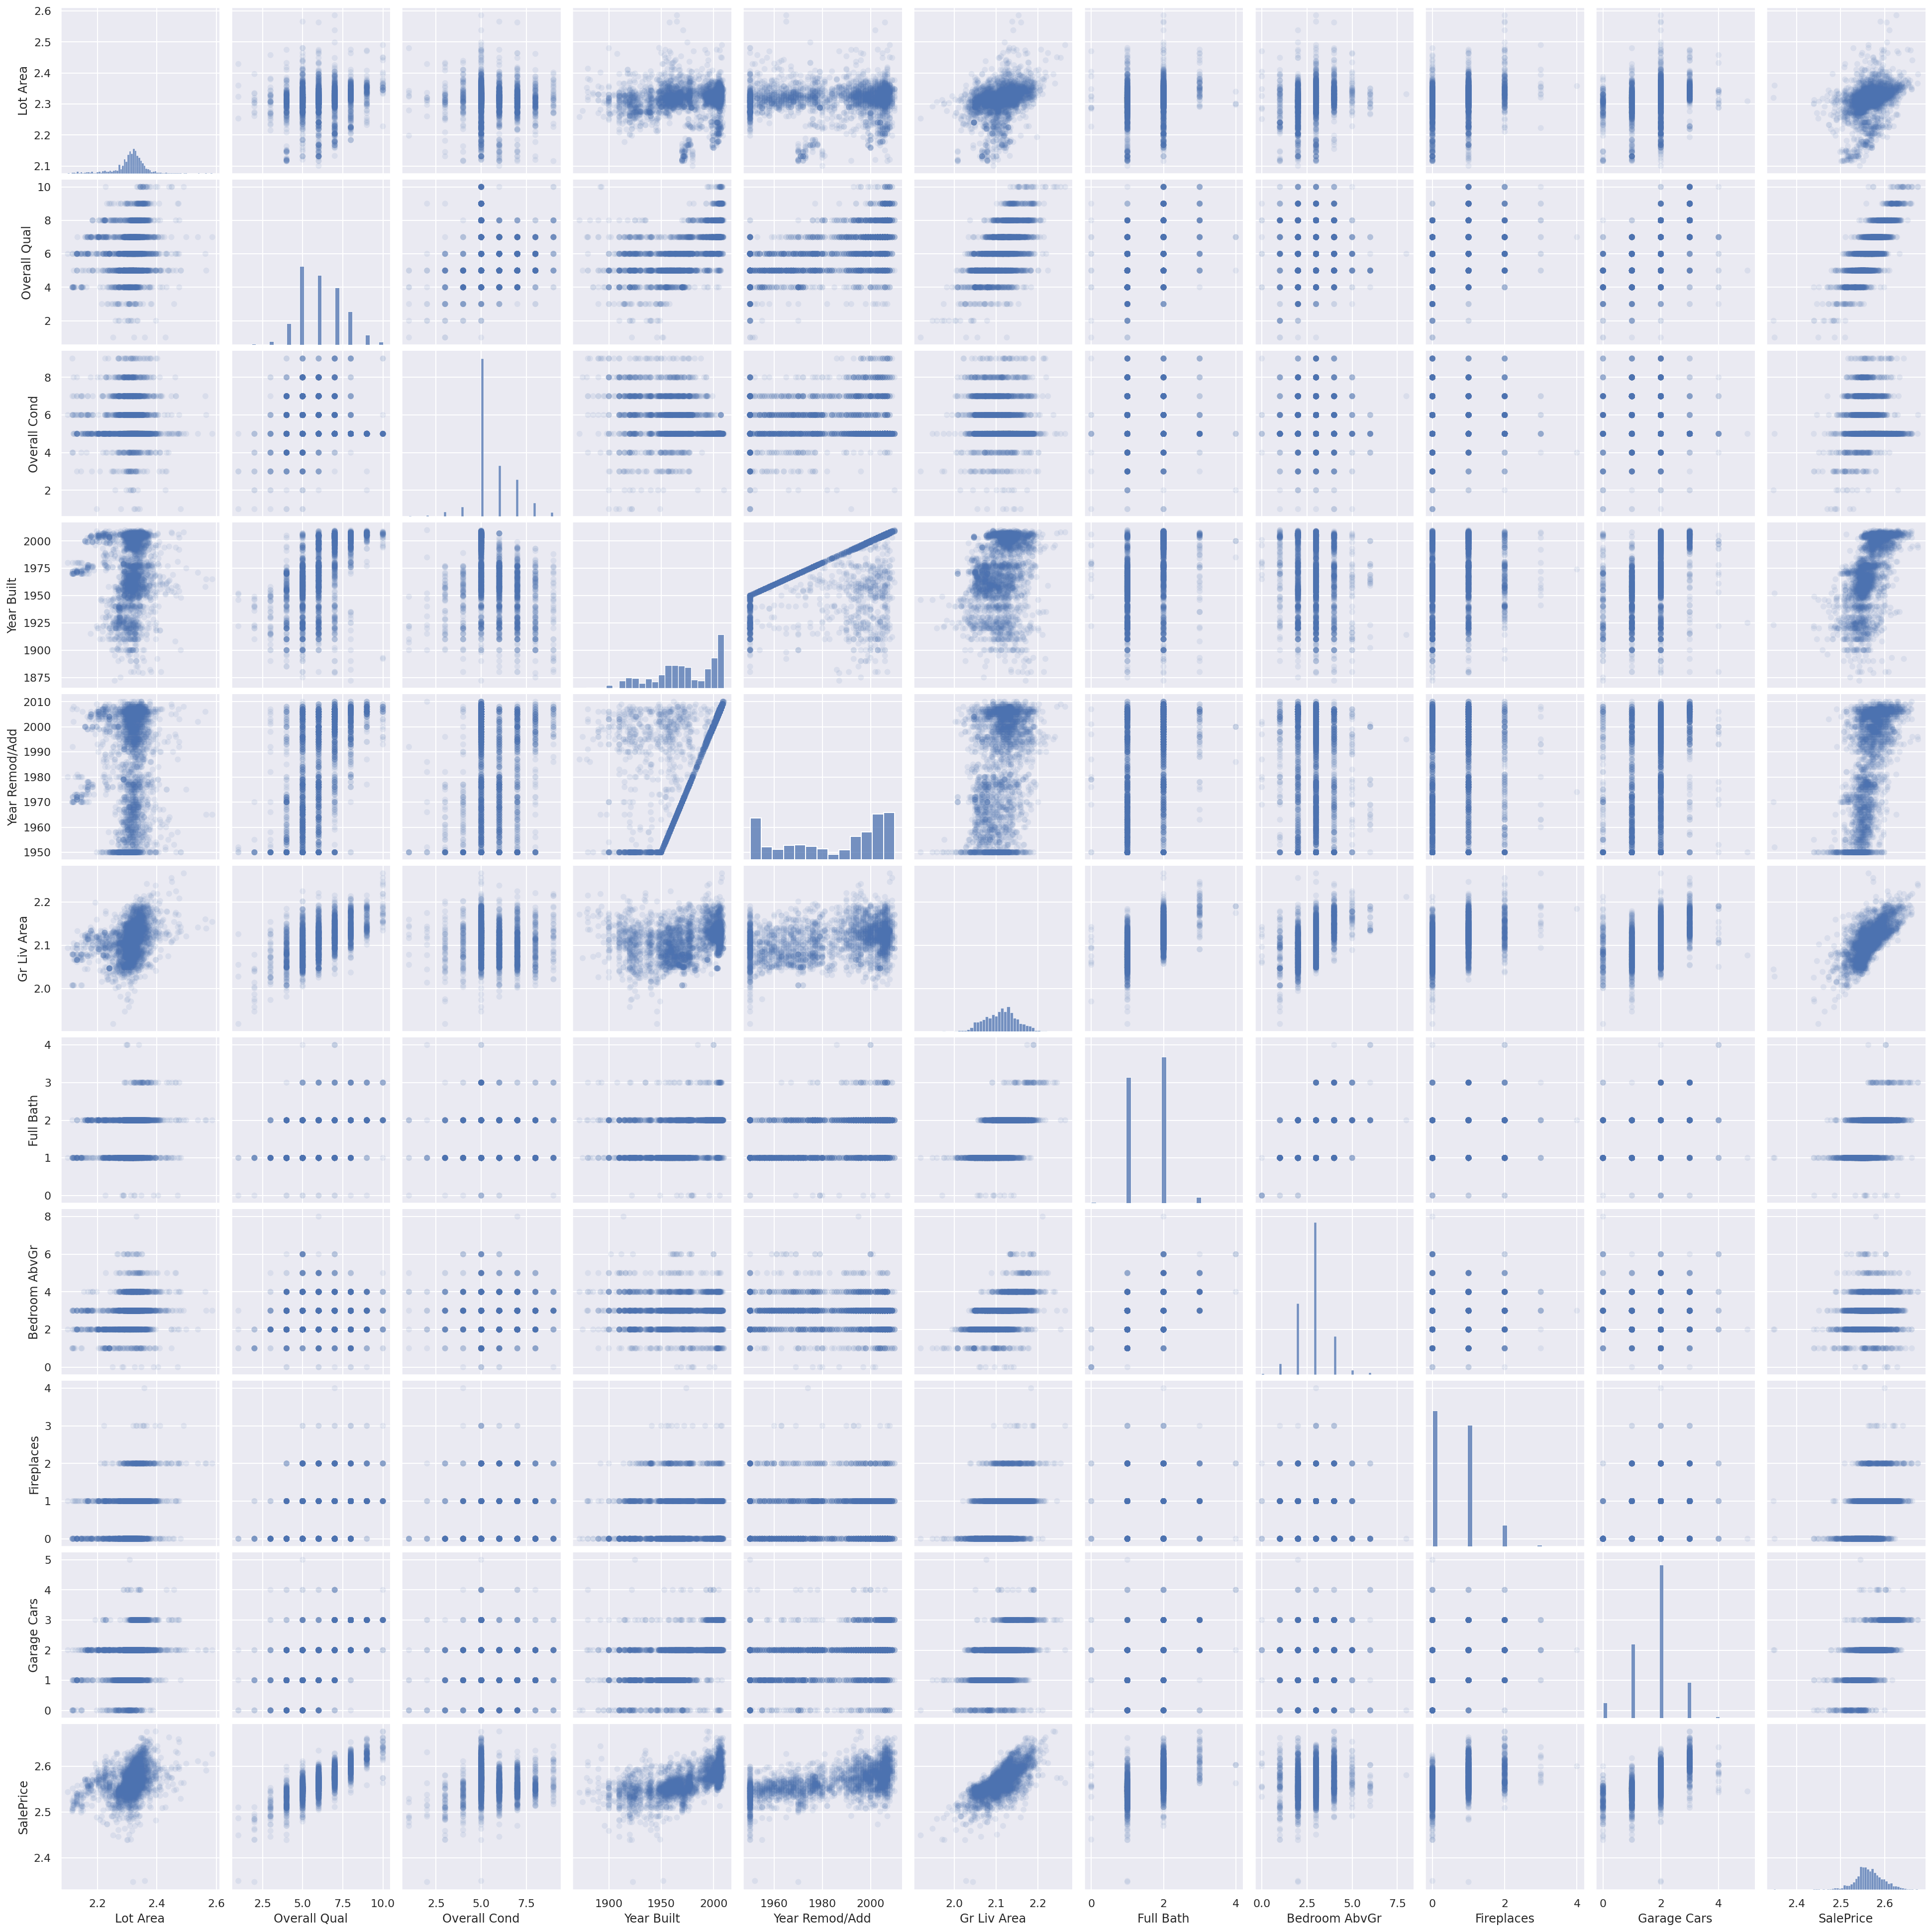

In [37]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

---
**Data Exploration Discussion**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---

#### Suppose our target variable is the SalePrice. We can set up separate variables for features and target.

In [38]:
#Separate our features from our target

X = smaller_df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars']]

y = smaller_df['SalePrice']

In [42]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2930 non-null   float64
 1   Overall Qual    2930 non-null   int64  
 2   Overall Cond    2930 non-null   int64  
 3   Year Built      2930 non-null   int64  
 4   Year Remod/Add  2930 non-null   int64  
 5   Gr Liv Area     2930 non-null   float64
 6   Full Bath       2930 non-null   int64  
 7   Bedroom AbvGr   2930 non-null   int64  
 8   Fireplaces      2930 non-null   int64  
 9   Garage Cars     2930 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 251.8 KB


Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

Great, let's go ahead and run this function on our baseline feature set and take some time to analyze the results.

### Basic feature engineering: adding polynomial and interaction terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. 
### Polynomial Features

In [43]:
X2 = X.copy()

X2['OQ2'] = X2['Overall Qual'] ** 2
X2['GLA2'] = X2['Gr Liv Area'] ** 2


As is, each feature is treated as an independent quantity. However, there may be **interaction effects**, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### Feature interactions

In [44]:
X3 = X2.copy()

# multiplicative interaction
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# division interaction
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']



-----
**Interaction Feature Exercise**: What other interactions do you think might be helpful? Why? 

-----

### Categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

In [45]:
data['House Style'].value_counts()

1Story    1481
2Story     873
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: House Style, dtype: int64

This looks ok, and here's a quick look at how dummy features actually appear:

In [46]:
pd.get_dummies(df['House Style'], drop_first=True).head()

1.5Unf  1Story  2.5Fin  2.5Unf  2Story  SFoyer  SLvl
0       0       1       0       0       0       0     0
1       0       1       0       0       0       0     0
2       0       1       0       0       0       0     0
3       0       1       0       0       0       0     0
4       0       0       0       0       1       0     0

We can call `pd.get_dummies()` on our entire dataset to quickly get data with all the original features and dummy variable representation of any categorical features. Let's look at some variable values.

In [47]:
nbh_counts = df.Neighborhood.value_counts()
nbh_counts

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

For this category, let's map the few least-represented neighborhoods to an "other" category before adding the feature to our feature set and running a new benchmark.

In [48]:
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)

other_nbhs

['Greens', 'GrnHill', 'Landmrk']

In [49]:
X4 = X3.copy()

X4['Neighborhood'] = df['Neighborhood'].replace(other_nbhs, 'Other')


In [52]:
X4.Neighborhood.value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Other       11
Blueste     10
Name: Neighborhood, dtype: int64

#### Getting to fancier features

Let's close out our introduction to feature engineering by considering a more complex type of feature that may work very nicely for certain problems. It doesn't seem to add a great deal over what we have so far, but it's a style of engineering to keep in mind for the future.

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

Below we define reusable code for generating features of this form, feel free to repurpose it for future feature engineering work!

In [ ]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

And now let's use our feature generation code to add 2 new deviation features, and run a final benchmark.

In [ ]:
X5 = X4.copy()
X5['House Style'] = df['House Style']
add_deviation_feature(X5, 'Year Built', 'House Style')
add_deviation_feature(X5, 'Overall Qual', 'Neighborhood')


## Polynomial Features in Scikit-Learn

`sklearn` allows you to build many higher-order terms at once with `PolynomialFeatures`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#Instantiate and provide desired degree; 
#   Note: degree=2 also includes intercept, degree 1 terms, and cross-terms

pf = PolynomialFeatures(degree=2)

In [ ]:
features = ['Lot Area', 'Overall Qual']
pf.fit(df[features])

In [ ]:
pf.get_feature_names()  #Must add input_features = features for appropriate names

In [ ]:
feat_array = pf.transform(df[features])
pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))

## Recap

While we haven't yet turned to prediction, these feature engineering exercises set the stage. Generally, feature engineering often follows a sort of [_Pareto principle_](https://en.wikipedia.org/wiki/Pareto_principle), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables can also be very helpful. Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth it depends on the use case for the model. 

---
### Machine Learning Foundation (C) 2020 IBM Corporation